# Project summary

## Background and Objectives
A taxi company has collected historical data on taxi orders at the airport.

To attract more drivers during peak hours, it is necessary to predict the number of taxi orders for the next hour. Several models for such prediction will be created and evaluated.

For evaluation, RMSE metric has been defined and must not exceed 48.

## Data Description
The data set is stored in the file *taxi.csv*. The number of orders is in the 'num_orders' column.

## Steps to take

1. Data loading
2. Data understanding
3. Make several model and test the data
4. Conclusion

# Data loading

### Import library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

### Import and check data

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])

In [ ]:
df.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [ ]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

- The passenger data (pax) for each day, recorded every 10 minutes, has been imported.
- It contains only two features: date/time and the total number of passengers (pax).
- The data format (datetime) has been parsed into datetime format.
- The average number of passengers during this period, for every 10 minutes, is approximately 14 pax. No missing data has been found.

# Data understanding

Check data trend, seasonality, and residual

In [ ]:
dfc = df.set_index('datetime')
decomposed = seasonal_decompose(dfc, period=6)

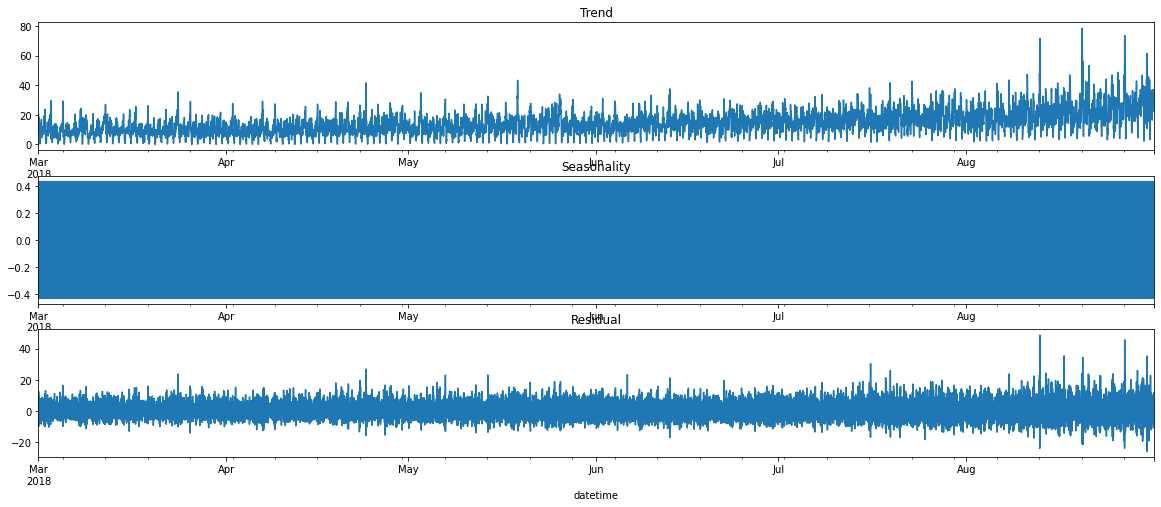

In [ ]:
plt.figure(figsize=(20,8))
0
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')

plt.show()

#### Findings:

- The data comprises the number of passengers each day, recorded every ten (10) minutes, from March until the end of August 2018.
- No missing data has been found.
- The data is very jagged (noisy) due to too much detail. It needs to be post-processed."

### Resampling data

In [ ]:
df1 = df.copy()
df1 = df1.set_index('datetime').resample('1h').sum()

In [ ]:
df1 = df1.set_index('datetime').resample('1h').sum()

In [ ]:
df1.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


### Visualize the total passenger (every 1 hour)

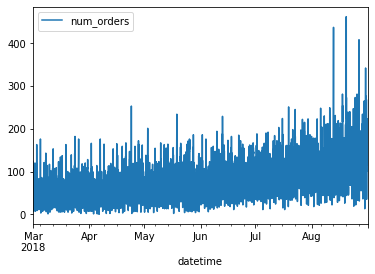

In [ ]:
df1.plot()
plt.show()

### Visualize the total passenger (every 1 day)

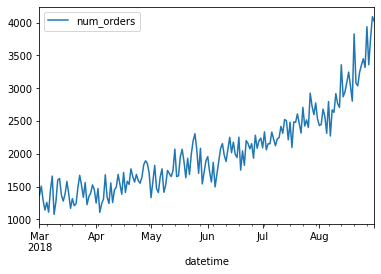

In [ ]:
df2 = df1.resample('1d').sum()
df2.plot()
plt.show()

### Visualize the total passenger (every 1 week)

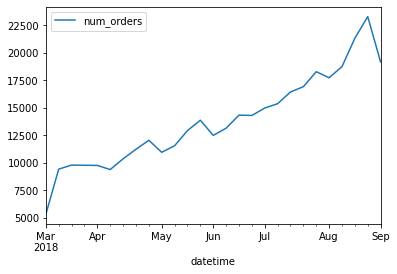

In [ ]:
df3 = df1.resample('1w').sum()
df3.plot()
plt.show()

### Visualize the total passenger (every 1 month)

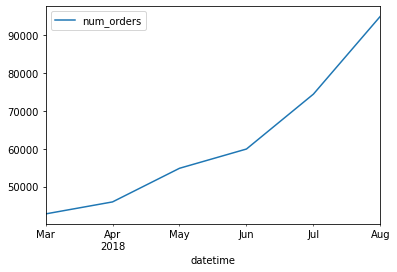

In [ ]:
df4 = df1.resample('1M').sum()
df4.plot()
plt.show()

- Data has rising trend. Not stationer

# Model and test data

### Traditional model

#### Splitting the data

Data is splitted into train and test. For time series analysis, shuffle parameter should be turn off

In [ ]:
train, test = train_test_split(df1, test_size=0.1, shuffle=False)

Visualize train test split

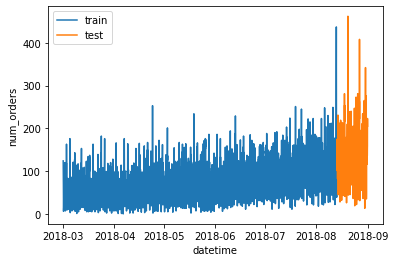

In [ ]:
sns.lineplot(train.index, train['num_orders'])
sns.lineplot(test.index, test['num_orders'])
plt.legend(labels=['train','test'])
plt.show()

In [ ]:
train = train['num_orders'].reset_index().set_index('datetime')
test = test['num_orders'].reset_index().set_index('datetime')

#### Model: Simple Exponential Smoothing

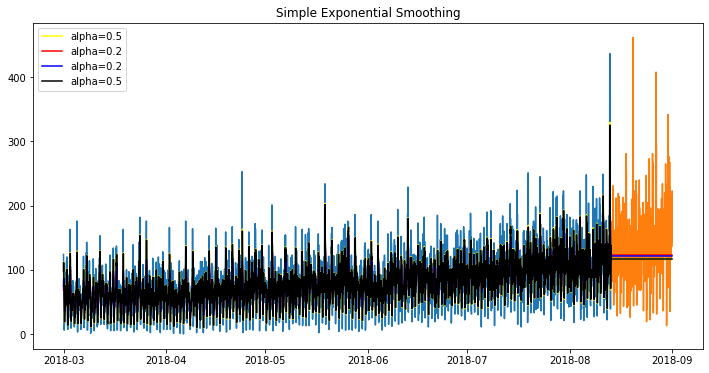

In [ ]:
model_simp_exp_smooth = SimpleExpSmoothing(np.asarray(train['num_orders']))

fit1 = model_simp_exp_smooth.fit()
pred1 = fit1.forecast(test.shape[0])

fit2 = model_simp_exp_smooth.fit(smoothing_level=.2)
pred2 = fit2.forecast(test.shape[0])

fit3 = model_simp_exp_smooth.fit(smoothing_level=.25)
pred3 = fit3.forecast(test.shape[0])

fit4 = model_simp_exp_smooth.fit(smoothing_level=.5)
pred4 = fit4.forecast(test.shape[0])

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train['num_orders'])
ax.plot(test['num_orders'])
for p, f, c in zip((pred1, pred2, pred3, pred4),(fit1, fit2, fit3, fit4),('yellow','red','blue','black')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label='alpha='+str(f.params['smoothing_level'])[:3], color=c)
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

In [ ]:
rmse_target = 48
rmse = (mean_squared_error(test, pred1)**0.5).round(2)
if rmse < rmse_target:
    notes = 'Model is good!'
else:
    notes = 'Model is no good, please to check!'
print('RMSE w/o smoothing:', rmse)
print(notes)

rmse = (mean_squared_error(test, pred2)**0.5).round(2)
print('RMSE w smoothing 20%:', rmse)
print(notes)

rmse = (mean_squared_error(test, pred3)**0.5).round(2)
print('RMSE w smoothing 25%:', rmse)
print(notes)

rmse = (mean_squared_error(test, pred4)**0.5).round(2)
print('RMSE w smoothing 50%:', rmse)
print(notes)

RMSE w/o smoothing: 62.77
Model is no good, please to check!
RMSE w smoothing 20%: 60.65
Model is no good, please to check!
RMSE w smoothing 25%: 61.4
Model is no good, please to check!
RMSE w smoothing 50%: 62.72
Model is no good, please to check!


Conclusion:

- Tweaking hyperparameters can yield results quickly.
- The current best model, with a 60.65% smoothing hyperparameter, almost reaches the target threshold of 48.
- There isn't much difference in the results when tweaking the hyperparameters. The RMSE remains around 60."

#### Model: Holt

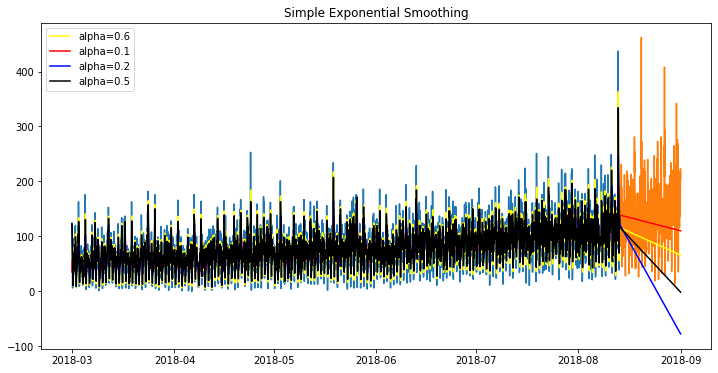

In [ ]:
model_simp_exp_smooth = Holt(np.asarray(train['num_orders']))

fit1 = model_simp_exp_smooth.fit()
pred1 = fit1.forecast(test.shape[0])

fit2 = model_simp_exp_smooth.fit(smoothing_level=.13)
pred2 = fit2.forecast(test.shape[0])

fit3 = model_simp_exp_smooth.fit(smoothing_level=.25)
pred3 = fit3.forecast(test.shape[0])

fit4 = model_simp_exp_smooth.fit(smoothing_level=.5)
pred4 = fit4.forecast(test.shape[0])

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train['num_orders'])
ax.plot(test['num_orders'])
for p, f, c in zip((pred1, pred2, pred3, pred4),(fit1, fit2, fit3, fit4),('yellow','red','blue','black')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label='alpha='+str(f.params['smoothing_level'])[:3], color=c)
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

In [ ]:
rmse_target = 48
rmse = (mean_squared_error(test, pred1)**0.5).round(2)
if rmse < rmse_target:
    notes = 'Model is good!'
else:
    notes = 'Model is no good, please to check!'
print('RMSE w/o smoothing:', rmse)
print(notes)

rmse = (mean_squared_error(test, pred2)**0.5).round(2)
print('RMSE w smoothing 13%:', rmse)
print(notes)

rmse = (mean_squared_error(test, pred3)**0.5).round(2)
print('RMSE w smoothing 25%:', rmse)
print(notes)

rmse = (mean_squared_error(test, pred4)**0.5).round(2)
print('RMSE w smoothing 50%:', rmse)
print(notes)

RMSE w/o smoothing: 79.77
Model is no good, please to check!
RMSE w smoothing 13%: 62.71
Model is no good, please to check!
RMSE w smoothing 25%: 148.52
Model is no good, please to check!
RMSE w smoothing 50%: 110.39
Model is no good, please to check!


Conclusion:

- Tweaking hyperparameters can lead to fast results.
- The current best model has a 25% smoothing hyperparameter.
- The RMSE is about 62.71, almost reaching the target threshold of 48.

#### Model: ARIMA

Choosing hyperparameter

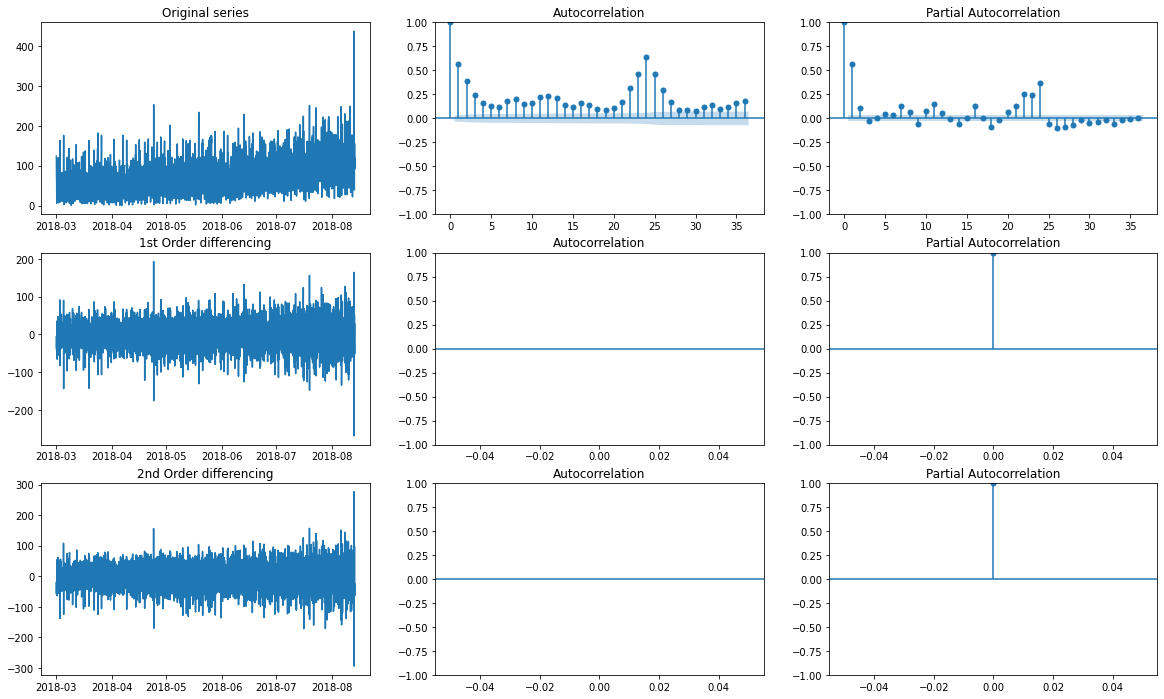

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes[0, 0].plot(train); axes[0, 0].set_title('Original series')
plot_acf(train, ax=axes[0, 1])
plot_pacf(train, ax=axes[0, 2])

axes[1, 0].plot(train.diff(1)); axes[1, 0].set_title('1st Order differencing')
plot_acf(train.diff(1), ax=axes[1, 1])
plot_pacf(train.diff(1), ax=axes[1, 2])

axes[2, 0].plot(train.diff(2)); axes[2, 0].set_title('2nd Order differencing')
plot_acf(train.diff(2), ax=axes[2, 1])
plot_pacf(train.diff(2), ax=axes[2, 2])

plt.show()

Hyperparameters are chosen as follows based on the study above:

- p: Lag order / autoregressive terms : 0
- d: Nonseasonal differences / degree of differencing : 1
- q: Lagged forecast errors in the prediction equation : 0
- ARIMA(p,q,d) -> ARIMA(0,1,0)"

In [ ]:
y = train['num_orders']

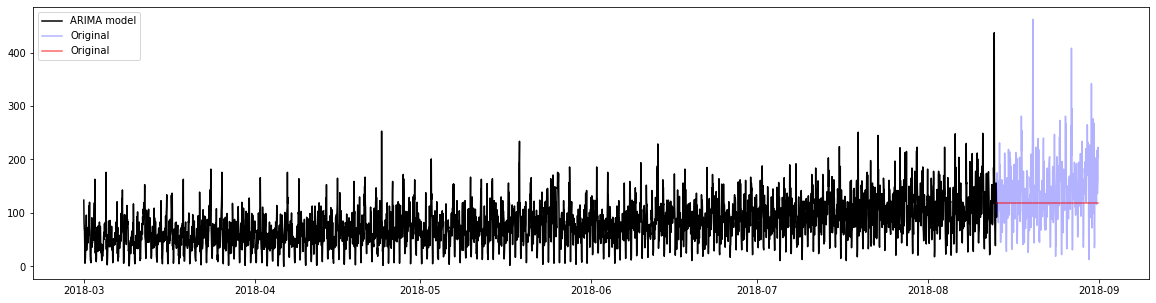

In [ ]:
model_arima = ARIMA(y, order=(0, 1, 0))
model_arima = model_arima.fit()

y_pred = model_arima.get_forecast(len(test))
y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = model_arima.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_out = y_pred_df['predictions']

plt.figure(figsize=(20,5))
plt.plot(train['num_orders'], color='Black', label='ARIMA model')
plt.plot(test['num_orders'], color='Blue', label='Original', alpha=0.3)
plt.plot(y_pred_out, color='Red', label='Original', alpha=0.6)
plt.legend()
plt.show()

In [ ]:
rmse_target = 48
rmse = (mean_squared_error(test, y_pred_out)**0.5).round(2)
if rmse < rmse_target:
    notes = 'Model is good!'
else:
    notes = 'Model is no good, please to check!'
print('RMSE:', rmse)
print(notes)

RMSE: 62.05
Model is no good, please to check!


Conclusion:

- Tweaking parameters can make the process run longer.
- The current best model has hyperparameters (0, 1, 0).
- The RMSE is about 62 and it is difficult to reach the target threshold of 48.

### Regression model

#### Model: Linear regression

Create a function to facilitate the analysis:

- The function should break down the datetime into (year, month, day, and day of the week).
- Generate new features for further analysis.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek


    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

In [ ]:
df_reg = df.set_index('datetime').resample('1h').sum()

Generate lag value for forecasting

In [ ]:
make_features(df_reg, 100, 30)

In [ ]:
df_reg = df_reg.dropna()

In [ ]:
df_reg.head(3)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,2018,3,5,0,51.0,32.0,176.0,86.0,68.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,53.066667
2018-03-05 05:00:00,16,2018,3,5,0,34.0,51.0,32.0,176.0,86.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,52.100000
2018-03-05 06:00:00,3,2018,3,5,0,16.0,34.0,51.0,32.0,176.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,51.200000


In [ ]:
train, test = train_test_split(df_reg, test_size=0.1, shuffle=False)

Setting up feature and target for each datasets

In [ ]:
x_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
x_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Train the model

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

Forecasting

In [ ]:
predict_model_train = model.predict(np.array(x_train))
predict_model_test = model.predict(np.array(x_test))

Find RMSE

In [ ]:
rmse_target = 48
rmse = (mean_squared_error(y_train, predict_model_train)**0.5).round(2)
if rmse < rmse_target:
    notes = 'Model is good!'
else:
    notes = 'Model is no good, please to check!'
print('RMSE:', rmse)
print(notes)

RMSE: 22.09
Model is good!


In [ ]:
rmse_target = 48
rmse = (mean_squared_error(y_test, predict_model_test)**0.5).round(2)
if rmse < rmse_target:
    notes = 'Model is good!'
else:
    notes = 'Model is no good, please to check!'
print('RMSE:', rmse)
print(notes)

RMSE: 41.79
Model is good!


Visualize / plot

In [ ]:
predict_model_train

array([ 33.09354472,  14.74393535,   9.79276347, ..., 124.59354472,
       123.68338847, 142.17557597])

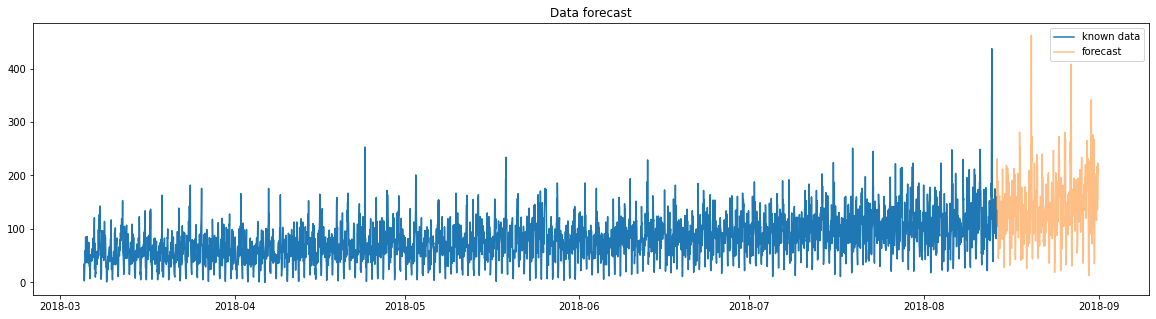

In [ ]:
plt.figure(figsize=(20,5))

# plt.plot(predict_model_train, label='forecasted data')
y_pred = pd.Series(predict_model_train, index=train.index)
plt.plot(y_train, label='known data')
plt.plot(y_test, alpha=0.5, label='forecast')
plt.title('Data forecast');

plt.legend()
plt.show()

#### Model: Random forest regression

In [ ]:
make_features(df_reg, 100, 20)

In [ ]:
df_reg = df_reg.dropna()

In [ ]:
df_reg.head(3)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-09 08:00:00,36,2018,3,9,4,16.0,4.0,1.0,30.0,31.0,...,85.0,62.0,50.0,59.0,31.0,14.0,3.0,16.0,34.0,57.65
2018-03-09 09:00:00,43,2018,3,9,4,36.0,16.0,4.0,1.0,30.0,...,37.0,85.0,62.0,50.0,59.0,31.0,14.0,3.0,16.0,57.05
2018-03-09 10:00:00,43,2018,3,9,4,43.0,36.0,16.0,4.0,1.0,...,58.0,37.0,85.0,62.0,50.0,59.0,31.0,14.0,3.0,56.85


In [ ]:
train, test = train_test_split(df_reg, test_size=0.1, shuffle=False)

Setting up feature and target for each datasets

In [ ]:
x_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
x_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [ ]:
rmse_target = 48
def iterate_model_rft(n, depth):
    for i, j in zip(range(1,n),range(1,depth)):
        model_rfr = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=12345)
        model_rfr.fit(x_train, y_train)
        predict_rfr_train = model_rfr.predict(x_train)
        predict_rfr_test = model_rfr.predict(x_test)
        rmse = (mean_squared_error(y_train, predict_rfr_train)**0.5).round(2)
        if rmse < rmse_target:
            notes = 'Model is good!'
        else:
            notes = 'Model is no good, please to check!'
        print(f'n: {i}')
        print(f'depth: {j}')
        print('RMSE:', rmse)
        print(notes)

In [ ]:
iterate_model_rft(100, 10)

n: 1
depth: 1
RMSE: 32.66
Model is good!
n: 2
depth: 2
RMSE: 28.21
Model is good!
n: 3
depth: 3
RMSE: 25.82
Model is good!
n: 4
depth: 4
RMSE: 23.83
Model is good!
n: 5
depth: 5
RMSE: 22.14
Model is good!
n: 6
depth: 6
RMSE: 20.58
Model is good!
n: 7
depth: 7
RMSE: 18.67
Model is good!
n: 8
depth: 8
RMSE: 16.92
Model is good!
n: 9
depth: 9
RMSE: 15.04
Model is good!


In [ ]:
model_rfr = RandomForestRegressor(n_estimators=9, max_depth=9, random_state=12345)
model_rfr.fit(x_train, y_train)
predict_rfr_train = model_rfr.predict(x_train)
predict_rfr_test = model_rfr.predict(x_test)
rmse = (mean_squared_error(y_train, predict_rfr_train)**0.5).round(2)

In [ ]:
rmse = (mean_squared_error(y_test, predict_rfr_test)**0.5).round(2)
if rmse < rmse_target:
    notes = 'Model is good!'
else:
    notes = 'Model is no good, please to check!'
print('RMSE:', rmse)
print(notes)

RMSE: 43.31
Model is good!


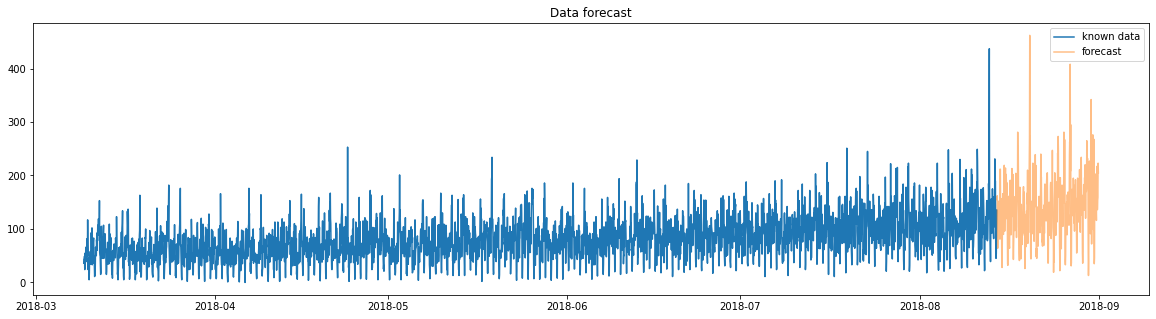

In [ ]:
plt.figure(figsize=(20,5))

# plt.plot(predict_model_train, label='forecasted data')
y_pred = pd.Series(predict_rfr_train, index=train.index)
plt.plot(y_train, label='known data')
plt.plot(y_test, alpha=0.5, label='forecast')
plt.title('Data forecast');

plt.legend()
plt.show()

## Conclusion

- Time series analysis of taxi num_orders has been conducted.
- Traditional and regression models have been exercised to forecast future taxi orders.
- The RMSE target for a good model is set at under 48.
- The simple exponential smoothing model has an RMSE of about 60 with a smoothing level of 25%.
- The Holt model has an RMSE of about 60 with a smoothing level of 25%.
- The ARIMA model has an RMSE of about 62 with hyperparameters (0, 1, 0).
- The linear regression model has an RMSE of about 42 (lag = 100).
- The random forest regression model also has an RMSE of about 42 (lag = 100, n_estimators = 100, depth = 10).
- The linear regression and random forest regression are the current best models, followed by simple exponential smoothing, Holt, and ARIMA models.